# Introduction

In this dataset I will employ a series of neural network models to predict the price of a used vehicle. The dataset used in this report has been sourced from Kaggle [1] and had originally contained exactly 3 million vehicles with 66 features. The original file is just under 10GB and as such I had sampled a small portion of this for the purposes of this project. The main objective of the project is to predict a numerical value, as such this is a regression task. All processing steps have been included below which involved downloading the file and selecting a small sample to work with.


#### Objectives
1. Sample the original dataset.
2. Pre-process the dataset - remove duplicates, transform data types.
3. Process the dataset - encode categorical data, apply feature scaling.
4. Test a series of models for hyperparameter selection.
5. Apply k-fold validation to select optimal epoch.
6. Train final tuned model and evaulate/predict the test set.


#### Aims
1. Develope a balanced model with low bias and low variance to accurately predict used vehicle prices.

### Problem Definition

###### What will the input data be?
A large number of features such as milage, make, model and horsepower, 26 features to be exact.

###### What will the output data be?
The dependant variable is the price of a vehicle.

###### Is the data complex enough to predict target variable?
The original dataset contains 66 features which in my opinon is complex enough for this task. 

###### What is the problem domain?
This is a regression task to predict the value of a vehicle given a number of features.

###### What is the measure of success?
The Mean Absolute Error value will be monitored for this regression task. 

## Pre-Processing the Dataset  - Part 1

### Sample and Feature Selection

In this section I will download the data and select the features I with to work with before applying rudimentary checks for duplicates, missing values and data type transformation.

In [1]:
# Importing necessary libraries.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from sklearn.model_selection import train_test_split
import seaborn as sns
import re

In [2]:
# Loading a sample of 20,000 rows from the entire dataset.

original_df = pd.read_csv('used_cars_data.csv', low_memory=False, nrows=20000)

In [3]:
# Examine all columns in the dataset.

original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 66 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   vin                      20000 non-null  object 
 1   back_legroom             18807 non-null  object 
 2   bed                      187 non-null    object 
 3   bed_height               1396 non-null   object 
 4   bed_length               1396 non-null   object 
 5   body_type                19922 non-null  object 
 6   cabin                    191 non-null    object 
 7   city                     20000 non-null  object 
 8   city_fuel_economy        16836 non-null  float64
 9   combine_fuel_economy     0 non-null      float64
 10  daysonmarket             20000 non-null  int64  
 11  dealer_zip               20000 non-null  int64  
 12  description              19574 non-null  object 
 13  engine_cylinders         19366 non-null  object 
 14  engine_displacement   

There are exactly 66 features contained in this dataset, some of which I feel will not contribute to the regression model. I will apply feature engineering and remove some columns which I feel are useless, such as 'bed, 'main picture url' and 'longitute'. All removed features were checked against the original dataset descriptions on Kaggle to confirm my decisions. 

In [4]:
# Selecting only the features with which to work with and saving to a new dataframe.

cars_df = original_df[['back_legroom', 'body_type', 'city_fuel_economy', 'engine_displacement', 'engine_type', 
                       'exterior_color', 'front_legroom', 'fuel_tank_volume', 'fuel_type', 'height', 'highway_fuel_economy',
                       'horsepower', 'interior_color', 'make_name', 'maximum_seating', 'mileage', 'model_name', 
                       'owner_count', 'power', 'torque', 'transmission', 'trimId', 'wheel_system', 'wheelbase', 'width', 
                       'year', 'price']]

### Data Type Transformation

The dataset contains 27 features, 7 of which should be of the data types floats or integer yet are objects due to non-numeric characters present in the entry. Examples of this are 'height' and 'back_legroom'. These data types must be processed into their respective logical forms before data scaling may be applied.

In [9]:
# Observe feature columns and data type. Most features are of incorrect dtype and require processing.

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   back_legroom          18807 non-null  object 
 1   body_type             19922 non-null  object 
 2   city_fuel_economy     16836 non-null  float64
 3   engine_displacement   18708 non-null  float64
 4   engine_type           19366 non-null  object 
 5   exterior_color        20000 non-null  object 
 6   front_legroom         18807 non-null  object 
 7   fuel_tank_volume      18807 non-null  object 
 8   fuel_type             19443 non-null  object 
 9   height                18807 non-null  object 
 10  highway_fuel_economy  16836 non-null  float64
 11  horsepower            18708 non-null  float64
 12  interior_color        20000 non-null  object 
 13  make_name             20000 non-null  object 
 14  maximum_seating       18807 non-null  object 
 15  mileage            

In [6]:
# Columns with non-numeric characters which need to be processed to float/int dtypes.

cars_df[['back_legroom', 'front_legroom',  'height', 'maximum_seating', 'wheelbase', 'width', 'fuel_tank_volume']].head()

,back_legroom,front_legroom,height,maximum_seating,wheelbase,width,fuel_tank_volume
0,35.1 in,41.2 in,66.5 in,5 seats,101.2 in,79.6 in,12.7 gal
1,38.1 in,39.1 in,68 in,7 seats,107.9 in,85.6 in,17.7 gal
2,35.4 in,43.3 in,58.1 in,5 seats,104.3 in,78.9 in,15.9 gal
3,37.6 in,39 in,73 in,7 seats,115 in,87.4 in,23.5 gal
4,38.1 in,39.1 in,68 in,7 seats,107.9 in,85.6 in,17.7 gal


In [8]:
# Removing all non-numeric characters from dataset for selected features.

cars_df.loc[:, ['back_legroom', 'front_legroom',  'height', 'maximum_seating', 'wheelbase', 'width', 
                'fuel_tank_volume']] = cars_df.loc[:, ['back_legroom', 'front_legroom',  'height', 
                                                       'maximum_seating', 'wheelbase', 'width', 
                                                       'fuel_tank_volume']].replace(r'[^\d.]+', '', regex=True)

In [10]:
# Processed features.

cars_df[['back_legroom', 'fuel_tank_volume', 'front_legroom', 'height', 'maximum_seating', 'wheelbase','width']].head()

,back_legroom,fuel_tank_volume,front_legroom,height,maximum_seating,wheelbase,width
0,35.1,12.7,41.2,66.5,5,101.2,79.6
1,38.1,17.7,39.1,68,7,107.9,85.6
2,35.4,15.9,43.3,58.1,5,104.3,78.9
3,37.6,23.5,39,73,7,115,87.4
4,38.1,17.7,39.1,68,7,107.9,85.6


With non-numeric carachters removed from applicable features they now need to be processed into the appropriate floats/int data types.

In [13]:
# Changing the data types for all features to numeric where applicable.

cars_df[['back_legroom', 'fuel_tank_volume', 'front_legroom', 'height', 'maximum_seating', 'wheelbase', 'width', 
         'year']] = cars_df[['back_legroom', 'fuel_tank_volume', 'front_legroom', 'height', 'maximum_seating', 
                             'wheelbase', 'width', 'year']].apply(pd.to_numeric)

In [14]:
# Processed data types.

cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   back_legroom          18207 non-null  float64
 1   body_type             19922 non-null  object 
 2   city_fuel_economy     16836 non-null  float64
 3   engine_displacement   18708 non-null  float64
 4   engine_type           19366 non-null  object 
 5   exterior_color        20000 non-null  object 
 6   front_legroom         18577 non-null  float64
 7   fuel_tank_volume      18799 non-null  float64
 8   fuel_type             19443 non-null  object 
 9   height                18802 non-null  float64
 10  highway_fuel_economy  16836 non-null  float64
 11  horsepower            18708 non-null  float64
 12  interior_color        20000 non-null  object 
 13  make_name             20000 non-null  object 
 14  maximum_seating       18802 non-null  float64
 15  mileage            

### Null Entries Removal

My next step is to remove null values from the dataset of which there are a multitude of columns with NA entries. While it is acceptable to allow missing values by imputating said values as 0 according to DLWP[2] (François Chollet, 2018), I have chosen to remove them because ratio of null values may be uneven during the train, test and validation splits the sets which will impede the convergence of gradient descent.

In [15]:
# Iterate through dataframe columns.
for column in cars_df.columns:
    
    # If sum of null entries is 0, ignore column.
    if cars_df[column].isnull().sum() == 0:
        continue
        
    # Display features with null entries.
    print(f'{column} - No. of NA entries: {cars_df[column].isnull().sum()}')

back_legroom - No. of NA entries: 1793
body_type - No. of NA entries: 78
city_fuel_economy - No. of NA entries: 3164
engine_displacement - No. of NA entries: 1292
engine_type - No. of NA entries: 634
front_legroom - No. of NA entries: 1423
fuel_tank_volume - No. of NA entries: 1201
fuel_type - No. of NA entries: 557
height - No. of NA entries: 1198
highway_fuel_economy - No. of NA entries: 3164
horsepower - No. of NA entries: 1292
maximum_seating - No. of NA entries: 1198
mileage - No. of NA entries: 544
owner_count - No. of NA entries: 7848
power - No. of NA entries: 2921
torque - No. of NA entries: 3141
transmission - No. of NA entries: 236
trimId - No. of NA entries: 973
wheel_system - No. of NA entries: 1138
wheelbase - No. of NA entries: 1198
width - No. of NA entries: 1198


In [16]:
# Drop rows with missing data.

cars_df.dropna(axis=0, how='any', inplace=True)

<ipython-input-16-3ed97c2a6ce3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars_df.dropna(axis=0, how='any', inplace=True)


The dataset has now been pre-processed and is ready for the main neural network processing phase.

## Processing the Dataset - Part 2

In this section the final steps will be taken before the dataset is ready for neural network input. The final steps are encoding the dataset and normalising the features.

### Encoding the Dataset

Categorical values such as the colour, model and fuel type must be encoded before it may be applied through a neural network. This will be accomplished using the pandas get_dummies function.

In [17]:
# Encoding the categorical values and assigning output to new dataframe.

dataset = pd.get_dummies(cars_df, columns=['body_type', 'engine_type', 'exterior_color', 'fuel_type', 'interior_color', 
                                           'make_name', 'model_name', 'power', 'torque', 'transmission', 'trimId', 
                                           'wheel_system'])

# Examine encoded df.
dataset.head()

,back_legroom,city_fuel_economy,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,maximum_seating,mileage,...,trimId_t9970,trimId_t9974,trimId_t9984,trimId_t9986,trimId_t9990,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD
12,35.1,22.0,3000.0,42.0,15.8,56.5,33.0,320.0,5.0,6903.0,...,0,0,0,0,0,0,0,1,0,0
38,38.1,27.0,1500.0,42.0,15.8,57.6,36.0,160.0,5.0,42394.0,...,0,0,0,0,0,0,0,0,1,0
40,27.3,18.0,3500.0,45.4,17.4,55.1,24.0,311.0,4.0,62251.0,...,0,0,0,0,0,0,0,1,0,0
41,38.4,18.0,3600.0,41.0,19.4,70.7,27.0,310.0,8.0,36410.0,...,0,0,0,0,0,0,0,0,1,0
45,36.8,15.0,3600.0,41.3,22.0,69.9,22.0,281.0,8.0,36055.0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
# Examine shape of encoded dataframe

dataset.shape

(9429, 7830)

In [19]:
# Check the data types.

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9429 entries, 12 to 19997
Columns: 7830 entries, back_legroom to wheel_system_RWD
dtypes: float64(14), int64(1), uint8(7815)
memory usage: 71.4 MB


This concludes the encoding of the categorical features of the dataset. The new dataset now contains 9429 rows and 7830 features. There are no longer any entries of object data type, all entries are now numerical.

### Train/Test Split

Before the dataset may be normalised it must be split into train and test partitions. This will be accomplished using the train test split sklearn function.

In [20]:
# Assign the independant features to X.
X = dataset.loc[:, dataset.columns != 'price']

# Assign the dependant feature to y and transform into an array.
y = dataset['price'].to_numpy()

# Split the dataset into train and test batches using the sklearn function.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

As observed only the dependant variable was transformed into a numpy array, the independant variables will be transformed below during the normalisation process.

### Feature Scaling

The dataset needs to be normalised before input into the neural network. Large values between features may result in large error gradient updates which inturn affect the weights and impede network convergence. Additionally it is also crucial to use the same scaling parameters which were used in normalisation of the training batch as on the testing batch. This is to ensure that no data is leaked between the train and test partitions as demonstrated in this [3] Machine Learning Mastery online article.

##### Normalisation vs Standardisation

In order to standardise the dataset we must ensure that the feature distributions are Gaussian with a well behaved mean and standard deviation. However even if the dataset does not fit these pre-requisites it is still possible to standardise at the cost of model bias. 

On the other hand normalisation requires an accurate estimate of the minimum and maximum observable values and is often used when standardisation is not optimal, summarised from the Machine Learning Mastery article on feature scaling [3].

Which wich feature scaling technique will be employed will be examined below by visualising the distribution of every numerical feature in the dataset.

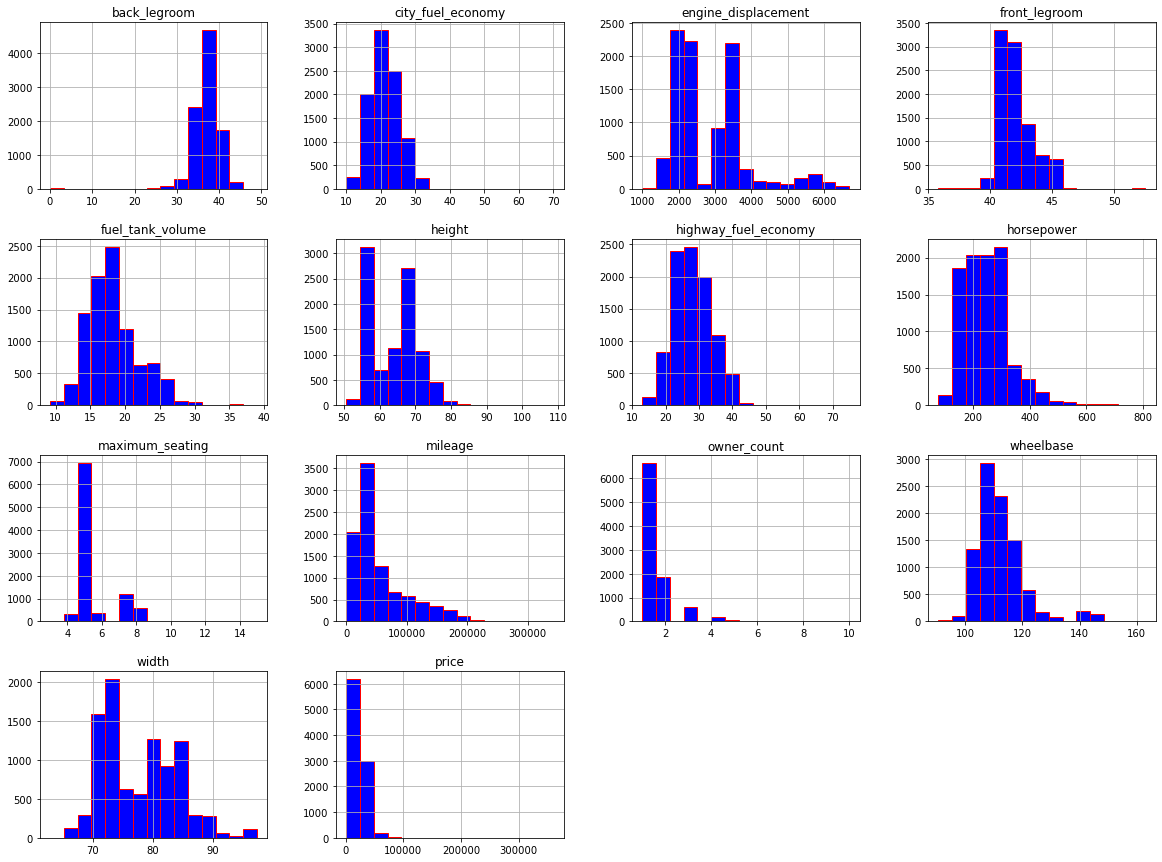

In [21]:
# Visualise the distribution of the numerical features.

dataset[['back_legroom', 'city_fuel_economy', 'engine_displacement', 'front_legroom', 'fuel_tank_volume', 'height', 
         'highway_fuel_economy', 'horsepower', 'maximum_seating', 'mileage', 'owner_count', 'wheelbase', 'width', 
         'price']].hist(bins=15, figsize=(20, 15), color='blue', edgecolor='red', layout=(4, 4), grid=True)

plt.show()

Examining the distribution of the numerical features in the dataset it is clear that many features do not fit a normal Gaussian distribution. Consequently it would then be advisable to use normalisation for the data scaling process. My inclination towards normalisation is further intensified by the knowledge that even with this small sample of the original dataset we still have an accurate observation of the minimum and maximum values for each feature. I believe we have these values within our sample due to the nature of the dataset. A vehicles tire width can only be so wide or so narrow, engine displacement on the used car market falls within an expected range and milage, while variable, does not usually exceed the the 300k range, nor can it be lower than 0. Therefore even a small sample can, with a high degree of certainty, capture the expected minimum and maximum values for most if not all features.

To conclude, normalisation will be used to scale the features.

###### Note to reader: Standardisation was employed and tested on this dataset and yielded worse results than normalisation in a series of trials.

In [22]:
# Initialising the normalisation scaler.
input_scaler = MinMaxScaler()

# Fit scaler to the training dataset.
input_scaler.fit(X_train)

# Normalise the training set.
X_train = input_scaler.transform(X_train)

# Normalise the test set using the 'train' parameters.
X_test = input_scaler.transform(X_test)

The predictor variable was ultimately not normalised after much deliberation with online sources and differing opinions, as visible in this [4] forum. From my understanding it is not necessary to scale the predictor variable unless said variable displays a high variance. Some opinions stated that no scaling need be applied to the output of regression problems and due to difficulty of un-scaling the data at the end of the training and testing phases the dependant variable was not normalised.

In conclusion the output variable will not be scaled.

This concludes the processing of the dataset, it has now been made ready for application to a series of neural network models.

# Methodology

My objective is to find the best fitting model with a low bias and high generalisation. My steps towards this goal are as follows:

1. Test a series of models with different neural and layer hyperparameters combinations.
2. Test a series of models with differing regularisation hyperparameters upon the previously selected model.
3. Use k-fold validation to test tuned hyperparameters and find the optimal epoch per fold.
4. Train final tuned model with the optimal hyperparameters for the optimal epochs.
5. Evaluate the model upon the test set.

#### Measure of Success - Low MAE values

## Multiple Model Testing

### Model Builder

In this section a series of models will be created and subsequently tested upon validation data. In order to achieve this and to avoid unecessary code repetition the function below has been created to aid in this process.

This model building function allows the user to select the number of layers, the number of neurons and the regularisation technique to apply, if desired.

In [23]:
def build_model(nb_layers=2, units=4, dropout=None, L1=None, L2=None):
    """
    This function creates a regression neural network model with RMSprop optimiser, 
    MSE loss and metric set to MAE. The activation function used is RELU and the 
    final layer is comprised of a single neuron.
    
    Inputs 
    nb_layers: The number of layers in the model.
    units: The number of neurons in each layer.
    dropout: If enabled will add a dropout layer corresponding to the input decimal. To enable 
    simply enter the decimal to apply as dropout.
    L1: adds l1 regularisation corresponding to the decimal input. To enable 
    simply enter the decimal to apply as l1 regularisation.
    L2: adds l2 regularisation corresponding to the decimal input. To enable 
    simply enter the decimal to apply as l2 regularisation.
    
    Output
    Returns a compiled model with the specified hyperparameters.
    """
    
    # Instantiate the neural network model.
    model = models.Sequential()
    
    # Boolean value to control and differentiate between the first and subsequent layers.
    first_layer = True
    
    # Looping through the number of layers.
    for layer in range(nb_layers):
        
        # Signify the first layer - which must be built differently to subsequent layers.
        if first_layer:
            
            # If L1 regularisation enabled.
            if L1:
                
                # Create ths first layer using the 'units' input as neurons, Relu activation function, 
                # input shape as determined by the training data and add l1 regularisation
                model.add(layers.Dense(units, kernel_regularizer=regularizers.l1(L1), 
                                       activation='relu', input_shape=(X_train.shape[1], )))
                
            # Check if L2 Regularisation enabled.    
            elif L2:
                
                # Create ths first layer using the 'units' input as neurons, Relu activation function, 
                # input shape as determined by the training data and add l2 regularisation
                model.add(layers.Dense(units, kernel_regularizer=regularizers.l2(L2), 
                                       activation='relu', input_shape=(X_train.shape[1], )))
                
            # If none enabled use standard layer.  
            else:
                
                # Create ths first layer using the 'units' input as neurons, Relu activation function, 
                # input shape as determined by the training data
                model.add(layers.Dense(units, activation='relu', input_shape=(X_train.shape[1], )))                

            # Add drop out layer if dropout decimal entered.
            if dropout:
                model.add(layers.Dropout(dropout))

            # Set boolean value to false so loop builds remaining layers using below layer layout.
            first_layer = False
        
        # Create remaining layers using the 'units' input as neurons.
        else:
            
            # Build layer using l1 regularisation if enabled.
            if L1:
                model.add(layers.Dense(units, kernel_regularizer=regularizers.l1(L1), activation='relu'))
            
            # Build layer using l2 regularisation if enabled.
            elif L2:
                model.add(layers.Dense(units, kernel_regularizer=regularizers.l2(L2), activation='relu'))
                
            # Build layer without any regularisation.
            else:
                model.add(layers.Dense(units, activation='relu'))
                                    
            # Add drop out layer if dropout is enabled.
            if dropout:
                model.add(layers.Dropout(dropout)) 
    
    # Add the final layer comprised of just one neuron for regression tasks.
    model.add(layers.Dense(1))
    
    # Compile the model using the below hyperparameters.
    model.compile(optimizer='rmsprop', loss='mse', metrics = ['mae'])
    
    # Return the compiled model.
    return model

The model builder will be used extensively in creating and validating multiple models with different hyperparamters in order to find the most stable, best fitting model.

### Testing a Series of Models

In this section I will be testing 24 models in a loop and saving their respective summaries and outputs for later analysis. These models will be trained for 200 epochs and a mini-batch size of 64. The batch size was selected as such due to the training tensor size which result in long training times even with this small sample. The epochs are limited to 200 to allow the networks to fully converge and for overfitting to occur.

In [16]:
# Creating a list of models with differing hyperparamters to train and validate.

models = [build_model(nb_layers=2, units=16),
          build_model(nb_layers=2, units=32),
          build_model(nb_layers=2, units=64),
          build_model(nb_layers=2, units=124),
          build_model(nb_layers=2, units=256),
          build_model(nb_layers=2, units=512),
          build_model(nb_layers=3, units=16),
          build_model(nb_layers=3, units=32),
          build_model(nb_layers=3, units=64),
          build_model(nb_layers=3, units=124),
          build_model(nb_layers=3, units=256),
          build_model(nb_layers=3, units=512),
          build_model(nb_layers=4, units=16),
          build_model(nb_layers=4, units=32),
          build_model(nb_layers=4, units=64),
          build_model(nb_layers=4, units=124),
          build_model(nb_layers=4, units=256),
          build_model(nb_layers=4, units=512),
          build_model(nb_layers=5, units=16),
          build_model(nb_layers=5, units=32),
          build_model(nb_layers=5, units=64),
          build_model(nb_layers=5, units=124),
          build_model(nb_layers=5, units=256),
          build_model(nb_layers=5, units=512)]


# Instantiating a list to record model summary.
model_summary = []

# Instantiating a dictionary to record model history.
histories = {}

# Looping through the model list.
for index, model in enumerate(models):
    
    # Save the model summary to the list.
    model_summary.append(model)
    
    # Track the iterations of the model list using print statements.
    print(f'Training model {index+1}/{len(models)}')
    
    # Train, validate and save model history to a disctionary.
    histories[f'model_{index+1}'] = model.fit(X_train, y_train, 
                                                 epochs=200, batch_size=64, 
                                                 validation_split=.2, verbose=0)
    
    # Print statement once all models have completed validation.
    if (index+1) == len(models):
        print('Training Complete')

Training model 1/24
Training model 2/24
Training model 3/24
Training model 4/24
Training model 5/24
Training model 6/24
Training model 7/24
Training model 8/24
Training model 9/24
Training model 10/24
Training model 11/24
Training model 12/24
Training model 13/24
Training model 14/24
Training model 15/24
Training model 16/24
Training model 17/24
Training model 18/24
Training model 19/24
Training model 20/24
Training model 21/24
Training model 22/24
Training model 23/24
Training model 24/24
Training Complete


With the model validation process complete I will now analyse the historic model data to uncover the optimal hyperparameters to use in the following section.

### Model Selection

In this section I will select the top five models from which to choose the best layer/neuron hyperparameter combination. The best model in this instance will be based upon the average of the five lowest mean absolute errors per model.

In order to accomplish this the model history previously stored will be used to create a dataframe from which the top five models can be selected and visualised.

In [17]:
# Creating a dataframe which contains the model and its respective MAE per epoch.

history_df = pd.DataFrame()
for i, v in histories.items():
    history_df[i] = v.history['val_mae']

The dataframe will now be used to create a list containing the respective model and its MAE value.

In [18]:
# Using list comprehension to get the mean of the 5 smallest MAE values per model.
mae_min_avg = [(model, round(np.mean(history_df[model].nsmallest(5, keep='first')),2)) for model in history_df]

# Sorting the list by MAE value.
mae_min_avg.sort(key=lambda x: x[1])

Looping through the sorted MAE array we can now rank all models and observe the most closely fitting models.

In [19]:
# Loop through the sorted list and print the model and its respective MAE value.

for index, model in enumerate(mae_min_avg):
    print(f'Rank {index+1}: {model[0]} = {model[1]}')

Rank 1: model_19 = 2407.81
Rank 2: model_13 = 2409.97
Rank 3: model_14 = 2417.35
Rank 4: model_15 = 2426.06
Rank 5: model_8 = 2429.51
Rank 6: model_9 = 2431.92
Rank 7: model_20 = 2432.33
Rank 8: model_7 = 2433.78
Rank 9: model_16 = 2447.02
Rank 10: model_11 = 2451.84
Rank 11: model_3 = 2460.07
Rank 12: model_5 = 2463.99
Rank 13: model_4 = 2468.06
Rank 14: model_6 = 2476.3
Rank 15: model_10 = 2500.73
Rank 16: model_21 = 2501.41
Rank 17: model_12 = 2512.83
Rank 18: model_22 = 2519.19
Rank 19: model_18 = 2537.1
Rank 20: model_17 = 2546.09
Rank 21: model_23 = 2558.76
Rank 22: model_24 = 2619.12
Rank 23: model_2 = 2696.16
Rank 24: model_1 = 3351.67


In order to better understand which model number corresponds to which hyperparameter layout the top 5 model summaries will be printed in sorted descending order.

In [20]:
# Loop through the top 5 models.
for model in mae_min_avg[:5]:
    
    # Remove non-numerical characters and subtract by 1 to align to the model training & saving process.
    model_id = int(re.sub('[^0-9]', '', model[0]))-1
    
    # Print the model summary and identifier.
    print(f'Model Number: {model_id+1}', model_summary[model_id].summary())
    print('\n')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 16)                125280    
_________________________________________________________________
dense_73 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_74 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_75 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_76 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 17        
Total params: 126,385
Trainable params: 126,385
Non-trainable params: 0
_______________________________________________

The results show that a lower capacity model comprised of 3+ layers is optmial for this dataset. The range between the top five models is small and in order to better understand the training process I will visualise the MAE per epoch to identify between models which overfit quickly vs those that do so slowly.

### Visualising Model Validation

In order to visualise the training and validation of the models I will filter the dataframe using a mask which will contain only the top 5 models we have previously examined.

In [21]:
# Creating a mask which will be used to filter the historical MAE dataframe.

mask = [model[0] for model in mae_min_avg[:5]]

In [22]:
# Filtering and creating a new dataframe which contains only the top 5 models.

top_5_models_df = history_df.filter(mask, axis=1)

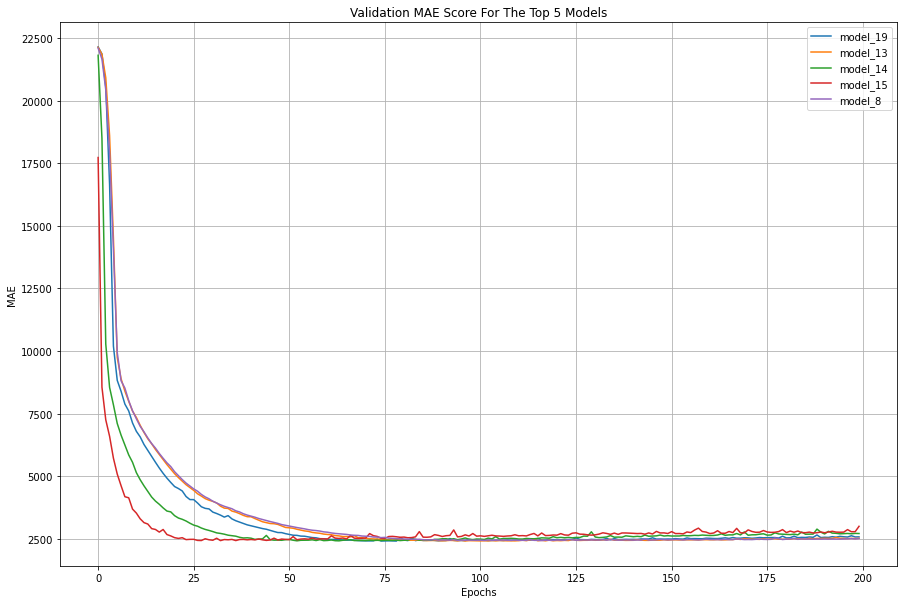

In [23]:
# Creating a plot from the new dataframe outlining top 5 models.

top_5_models_df.plot(figsize=(15,10), title='Validation MAE Score For The Top 5 Models', grid=True, 
                     xlabel ='Epochs', ylabel='MAE')
plt.show()

### Selecting the Model

Examining the models visualisations I believe we can immediately rule out model 15 which displays an unstable and volatile training process with frequent spikes in validation MAE.

Model 8 follows model 13 very closely with regards to the per epoch MAE, which is interesting given the disparity between the trainable parameters between the two models. Both models however take considerably longer to train which, while not a problem in a small sample such as this could provide issues in a real world scenario and could be impractical.

Model 19 has the lowest MAE average and on paper the best performance, however I believe that given enough iterations of the model testing phase we would find any of these top five models swapping ranks with each other. This model contains five layers, the deepest model in the hyperparameter space, and given that its contemporary models are less than four layers I believe this model over overfits the training set to a greater extent than the others. It may be difficult to generalise the model with so many hidden layers and therefore this model will be excluded.

This leaves just model 14 with 4 layers of 32 neurons each. In the plot this model shows a balanced training time versus the other top models while still maintaining low MAE error. These parameters will be used for the final model training and testing.

### Testing Regularisation Hyperparameters

The next step is to apply regularisation to the selected model. In order to accomplish this I will train a series of models with different regularisation techniques and record the loss and validation error which will be applied to the final model.

In this section I will examine the effects of L1, L2 and dropout methods of regularisation.

In [19]:
# Creating a list of models with differing regularisation hyperparamters to train and validate.

reg_models = [build_model(nb_layers=4, units=32, dropout=0.2),
              build_model(nb_layers=4, units=32, dropout=0.5),
              build_model(nb_layers=4, units=32, L1=0.001),
              build_model(nb_layers=4, units=32, L1=0.01),
              build_model(nb_layers=4, units=32, L2=0.001),
              build_model(nb_layers=4, units=32, L2=0.01),
              build_model(nb_layers=4, units=32, L2=0.001, L1=0.001),
              build_model(nb_layers=4, units=32, L2=0.01, L1=0.01),
              build_model(nb_layers=4, units=32, L1=0.001, dropout=0.2),
              build_model(nb_layers=4, units=32, L1=0.01, dropout=0.2),
              build_model(nb_layers=4, units=32, L2=0.001, dropout=0.2),
              build_model(nb_layers=4, units=32, L2=0.01, dropout=0.2),
              build_model(nb_layers=4, units=32, L2=0.001, L1=0.001, dropout=0.2),
              build_model(nb_layers=4, units=32, L2=0.01, L1=0.01, dropout=0.2),
              build_model(nb_layers=4, units=32, L1=0.001, dropout=0.5),
              build_model(nb_layers=4, units=32, L1=0.01, dropout=0.5),
              build_model(nb_layers=4, units=32, L2=0.001, dropout=0.5),
              build_model(nb_layers=4, units=32, L2=0.01, dropout=0.5),
              build_model(nb_layers=4, units=32, L2=0.001, L1=0.001, dropout=0.5),
              build_model(nb_layers=4, units=32, L2=0.01, L1=0.01, dropout=0.5)]


# Instantiating a dictionary to record model history.
reg_history = {}

# Looping through the model list.
for index, model in enumerate(reg_models):
    
    # Track the iterations of the model list using print statements.
    print(f'Training model {index+1}/{len(reg_models)}')
    
    # Train, validate and save model history to a disctionary.
    reg_history[f'model_{index+1}'] = model.fit(X_train, y_train, 
                                                epochs=200, batch_size=64, 
                                                validation_split=.2, verbose=0)
    
    # Print statement once all models have completed validation.
    if (index+1) == len(reg_models):
        print('Training Complete')

Training model 1/20
Training model 2/20
Training model 3/20
Training model 4/20
Training model 5/20
Training model 6/20
Training model 7/20
Training model 8/20
Training model 9/20
Training model 10/20
Training model 11/20
Training model 12/20
Training model 13/20
Training model 14/20
Training model 15/20
Training model 16/20
Training model 17/20
Training model 18/20
Training model 19/20
Training model 20/20
Training Complete


As before I will examine the minimum MAE errors by first creating a list with each models error, sorting the list and displaying the corresponding values in sorted order.

In [20]:
# Saving validation MAE histories to a list.
reg_mae = [(model[0], model[1].history['val_mae']) for model in reg_history.items()]

# Sorting the list by the min MAE value.
reg_mae.sort(key=lambda x: min(x[1]))

Using the sorted list each models minimum and avergae MAE values will be diplayed and used for selecting the optimal regularisation technique.

In [21]:
# Looping through list and printing the model number, min MAE value, optimal epoch and mean MAE per model.

for i in reg_mae:
    print(f'{i[0]} \nOptimal epoch: {np.argmin(i[1])} \tMinimum MAE: {round(min(i[1]))} \tAVG MAE: {round(np.mean(i[1]))}\n')

model_5 
Optimal epoch: 69 	Minimum MAE: 2409 	AVG MAE: 3110

model_8 
Optimal epoch: 59 	Minimum MAE: 2412 	AVG MAE: 3056

model_4 
Optimal epoch: 48 	Minimum MAE: 2422 	AVG MAE: 3000

model_7 
Optimal epoch: 73 	Minimum MAE: 2437 	AVG MAE: 3056

model_6 
Optimal epoch: 77 	Minimum MAE: 2706 	AVG MAE: 3192

model_10 
Optimal epoch: 60 	Minimum MAE: 2755 	AVG MAE: 3550

model_3 
Optimal epoch: 92 	Minimum MAE: 2761 	AVG MAE: 3275

model_13 
Optimal epoch: 56 	Minimum MAE: 2766 	AVG MAE: 3632

model_12 
Optimal epoch: 61 	Minimum MAE: 2781 	AVG MAE: 3623

model_14 
Optimal epoch: 60 	Minimum MAE: 2790 	AVG MAE: 3600

model_9 
Optimal epoch: 59 	Minimum MAE: 2804 	AVG MAE: 3674

model_1 
Optimal epoch: 57 	Minimum MAE: 2810 	AVG MAE: 3741

model_11 
Optimal epoch: 59 	Minimum MAE: 2851 	AVG MAE: 3790

model_17 
Optimal epoch: 42 	Minimum MAE: 3749 	AVG MAE: 4867

model_18 
Optimal epoch: 45 	Minimum MAE: 3831 	AVG MAE: 4790

model_20 
Optimal epoch: 59 	Minimum MAE: 3847 	AVG MAE: 4554



Judging from the ranked list it would seem that regularisation 'L2=0.001' would be optimal given that it produces the lowest MAE error. If however the mean MAE metric is prioritised then model 4 with 'L1=0.01' is the optimal regularisation parameter. 

The difference in the minimum MAE between both models is much smaller than the difference between the average MAE with regards to both models. Therefore I believe that 'L1=0.01' is the optimal hyperparameter as the minimum MAE can be fluctuate on each restart of the process.

### Optimal Epoch for Final Model

In this section I will apply the best hyperparameters to the K-fold validation in order to tune the epochs for final model application.

The batch size is reduced in this section as based upon multiple articles such as the effect of batch size on training and testing accuracy on 'Medium' [5] a small batch size provides higher model accuracy and improved generalisation capability. A large batch size may be used but the learning rate must be increased as a result to compensate. I believe that it is safer to use a smaller batch size with the recommended learning rate and as such learning rate hyperparameter was not tested in this project.

In [59]:
K = 4                   # Select number of folds.
num_epochs = 200        # Select number of epochs

all_mae_histories = []  # List for recording all fold MAE values.

# Splitting the independant and dependant arrays into K folds.
X_partition = np.array_split(X_train, K)
y_partition = np.array_split(y_train, K)


for i in range(K):
    print('Fold Number', i+1)

    # Prepare the validation data for independant and dependant variables: 
    X_validation = X_partition[i]
    y_validation = y_partition[i]

    # Prepare the independant feature trainig data from all other partitions not in the validation batch.
    X_partial_train = X_partition.copy()
    del X_partial_train[i]
    X_partial_train = np.concatenate(X_partial_train)

    # Prepare the dependant feature trainig data from all other partitions not in the validation batch.
    y_partial_train = y_partition.copy()
    del y_partial_train[i]
    y_partial_train = np.concatenate(y_partial_train)

    # Build the Keras model using tuned hyperparameters.
    model = build_model(nb_layers=4, units=32, L1=0.01)
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(X_partial_train, y_partial_train,
                        validation_data=(X_validation, y_validation),
                        epochs=num_epochs, batch_size=6, verbose=0) 
    
    # Retrieve validation MAE from the history.
    mae_history = history.history['val_mae']
    
    # Append validation MAE to list.
    all_mae_histories.append(mae_history)
    
    # Print the optimal epoch and lowest MAE value per fold.
    print('Optimal Epoch:', np.argmin(all_mae_histories[i]), '\tLowest Val_MAE:', round(min(all_mae_histories[i]),), '\n')
    
    # Print statement when all folds completed.
    if (i+1) == K:
        print('Training Complete')

Fold Number 1
Optimal Epoch: 50 	Lowest Val_MAE: 2316 

Fold Number 2
Optimal Epoch: 52 	Lowest Val_MAE: 2337 

Fold Number 3
Optimal Epoch: 32 	Lowest Val_MAE: 2474 

Fold Number 4
Optimal Epoch: 63 	Lowest Val_MAE: 2369 

Training Complete


The k-fold validation process is complete and we can now examine the results. The MAE values are quite low, compared to the previous trainig phases due to the reduced batch size. Using these values we can visualise the MAE and select the best epoch for the final model.

The fold details have been summarised below for easier visualisation.

In [60]:
for i in range(len(all_mae_histories)):
    print(f'Fold: {i+1} \tOptimal Epoch: {np.argmin(all_mae_histories[i])} \tLowest Val_MAE: {round(min(all_mae_histories[i]),2)}')

Fold: 1 	Optimal Epoch: 50 	Lowest Val_MAE: 2316.02
Fold: 2 	Optimal Epoch: 52 	Lowest Val_MAE: 2337.01
Fold: 3 	Optimal Epoch: 32 	Lowest Val_MAE: 2473.5
Fold: 4 	Optimal Epoch: 63 	Lowest Val_MAE: 2369.07


### Visualising the Training Process and Selecting the Optimal Epoch

The MAE histories will be visualised to understand the pattern behind the convergence process. Finally using this information we can make an educated selection for the most optimal epoch for the final model.

Code below is taken from Deep Learning with Python by François Chollet, 2021. [2]

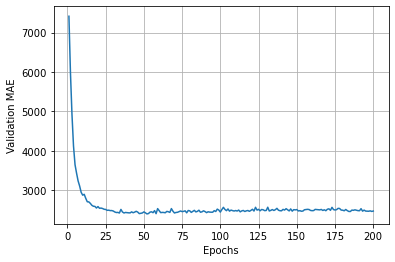

In [61]:
history_dict = history.history

average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.show()

To make the visualisation easier to interpret the smooth curve fuction will be employed.

Code below is taken from Deep Learning with Python by François Chollet, 2021. [2]

In [62]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

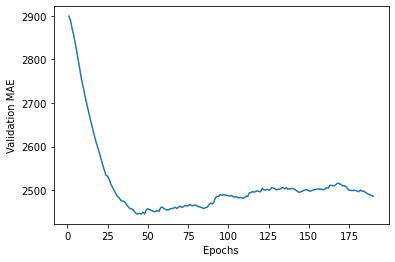

In [63]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

We can clearly discern that the optimal epoch lies somewhere between epoch 40 and 50 based upon the smooth MAE curve.

In [64]:
print(f'The optimal epoch is: {np.argmin(average_mae_history)}')

The optimal epoch is: 51


Using this information we can now train our final model which will be used to predict the test set.

## Final Model Results

### Evaluation

The final model is built using the tuned hyperparameters and trained for the optimal epochs as previously defined.

In [26]:
# Building a model with tuned hyperparameters on the whole training set.

model = build_model(nb_layers=4, units=32, L1=0.01)
history = model.fit(X_train, y_train,
                    epochs=51, 
                    batch_size=6, 
                    verbose=0)

Finally it is time to evaluate the model on the test set.

In [27]:
# Evaluating the model on the test set.

test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

print(f'MAE - ${round(test_mae_score,2)}')

59/59 [==============================] - 0s 1ms/step - loss: 16551030.0000 - mae: 2249.6367
MAE - $2249.64


Our model error is provided above, which is the average absolute error of the prediction against the actual price of the vehicle. Interestingly the MAE falls inline with the previous validation MAE errors which implies that the regularisation process was effective.

### Prediction

Lastly, to put it all in perspective I will use the model to predict the values of the test set and visualise the results. 

In [28]:
# Predicting the model on the test set.

y_pred = model.predict(X_test)

Using these predictions we can create a new dataframe to visualise the errors and predictions made by the model against the actual values.

In [35]:
# Saving results to a dataframe with appropriate column names.
results = pd.DataFrame(y_pred, y_test, columns=['Prediction']).reset_index().rename({'index': 'Actual'}, axis=1)

# Creating new column for errors.
results['Error'] = results['Actual'] - results['Prediction']

# Examine dataframe.
results.head(10)

,Actual,Prediction,Error
0,20888.0,18043.189453,2844.810547
1,64995.0,53425.300781,11569.699219
2,38995.0,37884.324219,1110.675781
3,13931.0,15658.670898,-1727.670898
4,34888.0,29922.720703,4965.279297
5,52995.0,130959.914062,-77964.914062
6,19488.0,21830.927734,-2342.927734
7,4499.0,4671.991699,-172.991699
8,33699.0,38330.726562,-4631.726562
9,16495.0,17244.339844,-749.339844


The model can be quite accurate for certain entries and fairly innacurate for others. I will use a hist plot to visualise the error distribution. In addition to the visualisation It would be worthwhile to check the basic statistical breakdown of the errors. 

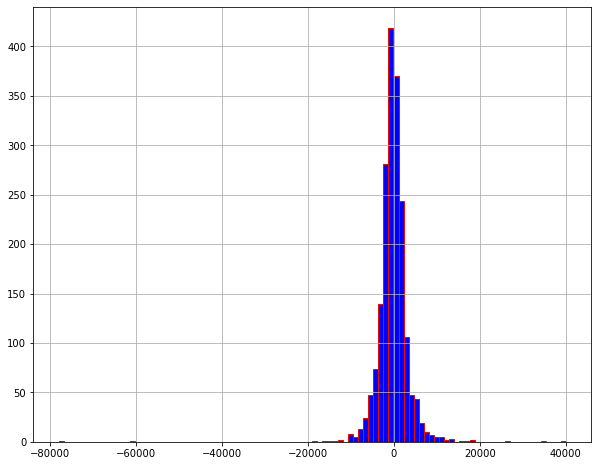

In [65]:
# Using distplot to visualise errors.

results['Error'].hist(bins=100, figsize=(10, 8), color='blue', edgecolor='red', grid=True)

plt.show()

In [85]:
print(f"The Minimum Error: \t${round(results['Error'].abs().min(),2)}")
print(f"The Maximum Error: \t${round(results['Error'].abs().max(),2)}")
print(f"The Average Error: \t${round(results['Error'].abs().mean(),2)}")
print(f"The 1st Quartile Error: ${round(results['Error'].abs().quantile(0.25),2)}")
print(f"The Median Error: \t${round(results['Error'].abs().median(),2)}")
print(f"The 3rd Quartile Error: ${round(results['Error'].abs().quantile(0.75),2)}")
print(f"The Standard Deviation: ${round(results['Error'].abs().std(),2)}")

The Minimum Error: 	$0.04
The Maximum Error: 	$77964.91
The Average Error: 	$2249.64
The 1st Quartile Error: $677.57
The Median Error: 	$1442.89
The 3rd Quartile Error: $2787.46
The Standard Deviation: $3390.61


The histogram shows that most errors congregate around zero which is as expected. Surprisingly the smallest error was an almost perfect prediction of the actual price.

From the graph we can also discern that the network undervalued vehicles to a higher degree than it has overvalued. The largest absolute errors are also very large when compared to the error distribution. 

The data behind these large errors should be further examined as there may be an underlying issue with the training data which led to abnormal error values. This is further reinforced by the considerably lower median, by roughly $1,000, than the mean value which is influenced by these large errors.

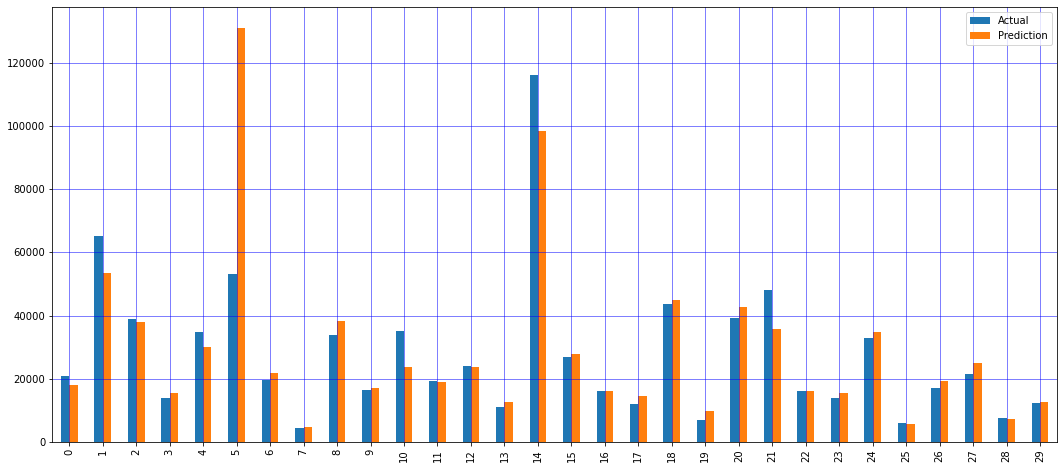

In [86]:
# Examining the actual and predicted values for the first 30 vehicles in the dataframe.

results[['Actual', 'Prediction']][:30].plot(kind='bar',figsize=(18,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='blue')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='green')

plt.show()

## Conclusion

The goal of this project was to develope a balanced model with a low bias and low variance. I believe, having examined the tuned models performance, that this objective has been achieved. The final model has performed reasonably well, especially when the median error value is observed.

There is room for improvement however, without a doubt. There are a number of high error values which need to be adressed. I believe that there could exist an issue with the training data which the model was unable to accurately learn. Had I more time and the ability to re-do this project I would examine all the high error values and determine whether they are somehow related or whether the model simply did not have enough training data for this type of vehicle.

One possible issue with this project is the long training period for validating multiple hyperparameters, combined with the k-fold epoch testing. I understand that in a real life scenario this would be impractical. This is further reiterated by the fact that only 20k rows were used from the original 3 million. Even with such a small dataset training periods are long on standard hardware.

Another potential issue is that the high number of hyperparameter tests upon the validation set could result in data leakage. While I do not suspect that the model suffers from this as the error values have remianed consistent with the test errors it may have influenced the optimal hyperparameter selection and I wonder whether a different train\test split would result in a different series of top 5 models. This issue could be counteracted with more training data.


##### How to improve model performance.

The obvious way to improve the models cability to predict is to use more data. While I would have relished the opprtunity to use all 3 million entries for model training it was not feasible on my current PC. However in a real life scenario the entirety of the data should be used for training/testing.

The larger dataset would have also improved the data scaling process on the testing set, as the parameters used for training were used to scale the test set. The critical point here is normalisations requirement for the accurate maximum and minimum values, which would have improved the accuracy of these values and better generalise on unseen data.

Lastly, through configuration of the batch size it is possible to achieve improvements to the bias and variance of the model. As previously mentioned in the Medium article [5] the batch size has a noticiable effect on model capability and I can verify these claims through my own experimentation. A large batch size would significantly increase the neuron requirement for low bias. In my experiments upon this dataset a batch size of 512 would result in neurons of 124-512 to be selected as the optimal values. When decreasing the batch size to 64, the corresponding optimal neuron count fell to a range 16-64. From these finding I can conclude that a batch size of 1 will result in the most optimal model training. This would however take a considerably long time and is impractical even on a small dataset such as this.

## References

[1] Kaggle.com. 2021. US Used cars dataset. [online] Available at: <https://www.kaggle.com/ananaymital/us-used-cars-dataset> [Accessed 5 December 2021].

[2] CHOLLET, F., 2021. DEEP LEARNING WITH PYTHON. [S.l.]: O'REILLY MEDIA.

[3] Brownlee, J., 2021. How to use Data Scaling Improve Deep Learning Model Stability and Performance. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/> [Accessed 5 December 2021].

[4] analysis?, I., Collins, J. and Wittmann, F., 2021. Is it necessary to scale the target value in addition to scaling features for regression analysis?. [online] Cross Validated. Available at: <https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re> [Accessed 5 December 2021].

[5] Medium. 2021. Effect of batch size on training dynamics. [online] Available at: <https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e> [Accessed 5 December 2021].